# Librerías a utilizar

In [2]:
!pip install pmdarima
!pip install --upgrade --force-reinstall numpy==1.24.4 scipy==1.10.1


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 15.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cvxpy 1.6.6 requires scipy>=1.11.0, but you have scipy 1.10.1 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
jaxlib 0.5.1 requires scipy>=1.11.1, but y

In [1]:

# --- Carga de datos ---
from google.colab import files  # Para cargar archivos desde el entorno local
import os  # Operaciones con el sistema de archivos
import random  # Reproducibilidad aleatoria

# --- Manipulación de datos ---
import pandas as pd  # Para manipulación de datos
import numpy as np  # Para cálculos numéricos

# --- Visualización ---
import matplotlib.pyplot as plt  # Para visualización de datos

# --- Modelado estadístico y series temporales ---
import statsmodels.api as sm  # Modelos estadísticos
from statsmodels.tsa.stattools import adfuller  # Test de Dickey-Fuller
from statsmodels.tsa.seasonal import seasonal_decompose  # Descomposición estacional
from statsmodels.stats.diagnostic import acorr_ljungbox, het_breuschpagan  # Tests de diagnóstico

# --- Pruebas estadísticas ---
from scipy.stats import shapiro  # Test de normalidad de Shapiro-Wilk

# --- Modelado automático ARIMA ---
#!pip install --upgrade --force-reinstall numpy
#!pip install --no-cache-dir --force-reinstall pmdarima

import pmdarima as pm  # Para auto_arima


Lectura de las bases de datos

In [ ]:
uploaded = files.upload()

Saving Datos_290004_con_predicciones_covariables_filtrado 2024.xlsx to Datos_290004_con_predicciones_covariables_filtrado 2024.xlsx


In [8]:
base_estacion_290004_24_25= pd.read_excel("Datos_290004_con_predicciones_covariables_filtrado_2024.xlsx")

#Velocidad del viento en nudos (1 nudo equivale aproximadamente a 1.852 km/h)
serie2 = base_estacion_290004_24_25["ff_Valor"]

df=base_estacion_290004_24_25.copy()


# EDA

# Revisión de supuestos ARIMA/SARIMA

Se realizará un único "Chunk" para verificar estacionariedad, no autocorrelación entre los residuos, normalidad de los residuos, homocedasticidad de varianza de los residuos, estacionalidad (para SARIMA) y además se verificarán valores atípicos extremos, debido a que los modelos ARIMA/SARIMA son sensible a outliers, por lo que conviene detectar valores atípicos, y en caso de existencia de muchos aplicar un suavizamiento o transformación

# **Arima**

In [ ]:
# ENTRENAMIENTO Y GUARDADO DEL MODELO ARIMAX
import pandas as pd
import numpy as np
import joblib
from pmdarima import auto_arima

# 1. Definir columnas
BASE_FEATURES = ["dd_Valor", "VRB_Valor", "Presion_QFE", "Temperatura", "Presion_QFF"]
CYCLIC_FEATS  = ["hora_sin", "hora_cos", "doy_sin", "doy_cos"]
FEATURES = BASE_FEATURES + CYCLIC_FEATS

# 2. Cargar datos completos
datos = pd.read_excel("Datos_290004_con_predicciones_covariables_filtrado 2024.xlsx")
datos["momento"] = pd.to_datetime(datos["momento"])
datos = datos.sort_values("momento").reset_index(drop=True)

# 3. Crear variables cíclicas
datos["hora"] = datos["momento"].dt.hour
datos["doy"]  = datos["momento"].dt.dayofyear
datos["hora_sin"] = np.sin(2 * np.pi * datos["hora"] / 24)
datos["hora_cos"] = np.cos(2 * np.pi * datos["hora"] / 24)
datos["doy_sin"]  = np.sin(2 * np.pi * datos["doy"] / 365)
datos["doy_cos"]  = np.cos(2 * np.pi * datos["doy"] / 365)

# 4. Separar conjunto de entrenamiento
entrenamiento = datos.iloc[:13143].dropna(subset=["ff_Valor"] + FEATURES).copy()#13.143
y_train = entrenamiento["ff_Valor"]
X_train = entrenamiento[FEATURES].astype(float)

# 5. Entrenar modelo
print("Entrenando modelo ARIMAX...")
modelo = auto_arima(
    y_train,
    exogenous=X_train,
    seasonal=False,
    stepwise=True,
    suppress_warnings=True,
    error_action='ignore',
    trace=True
)

# 6. Guardar modelo y columnas
joblib.dump(modelo, "modelo_arimax.pkl")
joblib.dump(FEATURES, "features_usadas.pkl")
print("Modelo y columnas guardadas correctamente.")


Entrenando modelo ARIMAX...
Performing stepwise search to minimize aic


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=59550.522, Time=31.86 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=59801.473, Time=0.45 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=59567.005, Time=1.13 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=59554.196, Time=2.52 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,0)[0]             : AIC=59799.473, Time=0.27 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=59553.535, Time=9.07 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=59551.901, Time=16.90 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=59547.892, Time=42.61 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=59553.431, Time=4.00 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=59546.436, Time=58.95 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=59555.407, Time=7.26 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=66.35 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=59550.854, Time=46.19 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=59546.360, Time=57.05 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=59547.053, Time=43.66 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=75.65 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=59193.873, Time=66.98 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=54.46 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,5)(0,0,0)[0] intercept   : AIC=inf, Time=65.52 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=59553.771, Time=7.26 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=inf, Time=55.61 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,5)(0,0,0)[0] intercept   : AIC=inf, Time=77.28 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,4)(0,0,0)[0]             : AIC=56749.371, Time=21.25 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,4)(0,0,0)[0]             : AIC=inf, Time=17.51 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[0]             : AIC=59545.053, Time=12.28 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,4)(0,0,0)[0]             : AIC=inf, Time=19.51 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,5)(0,0,0)[0]             : AIC=inf, Time=29.20 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,0)[0]             : AIC=59551.771, Time=2.47 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,5)(0,0,0)[0]             : AIC=inf, Time=11.84 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(0,0,0)[0]             : AIC=inf, Time=62.86 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,5)(0,0,0)[0]             : AIC=inf, Time=36.77 sec

Best model:  ARIMA(2,1,4)(0,0,0)[0]          
Total fit time: 1004.742 seconds
Modelo y columnas guardadas correctamente.


In [ ]:
print(modelo.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                13141
Model:               SARIMAX(2, 1, 4)   Log Likelihood              -28367.686
Date:                Tue, 08 Jul 2025   AIC                          56749.371
Time:                        02:44:37   BIC                          56801.755
Sample:                             0   HQIC                         56766.865
                              - 13141                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9190      0.002   1092.398      0.000       1.916       1.922
ar.L2         -0.9834      0.002   -569.203      0.000      -0.987      -0.980
ma.L1         -2.3352      0.007   -312.277      0.0

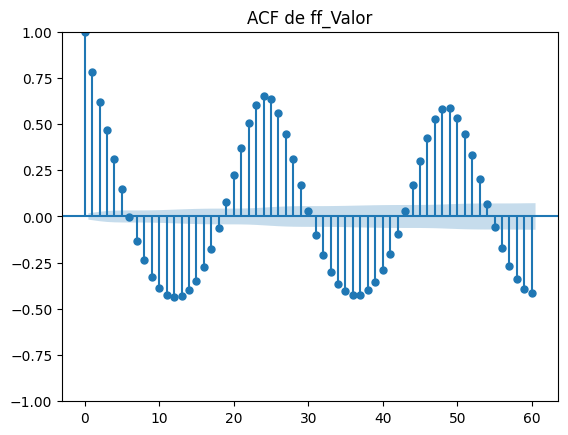

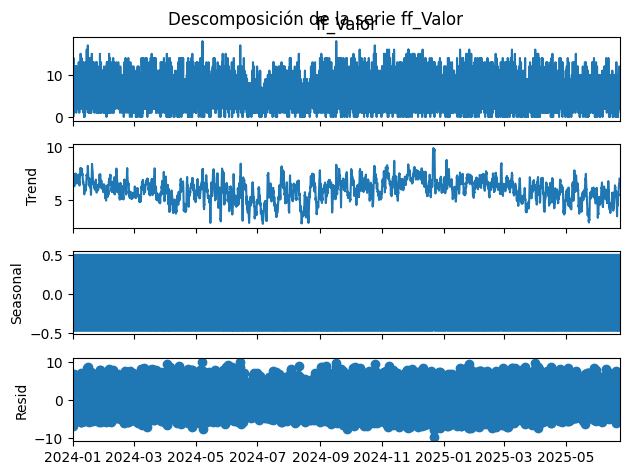

ADF Test p-value: 2.439297591400289e-24


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# 1. Asegurar formato de fecha
datos["momento"] = pd.to_datetime(datos["momento"])
datos = datos.sort_values("momento")

# 2. Establecer índice temporal
serie = datos.set_index("momento")["ff_Valor"].dropna()

# 3. Graficar autocorrelación
plot_acf(serie, lags=60)
plt.title("ACF de ff_Valor")
plt.show()

# 4. Descomposición estacional (solo si frecuencia lo permite, ej: diaria con datos horarios)
descomposicion = seasonal_decompose(serie, model='additive', period=24)  # ajusta si es diario/mensual
descomposicion.plot()
plt.suptitle("Descomposición de la serie ff_Valor")
plt.show()

# 5. Prueba Dickey-Fuller (ADF)
resultado_adf = adfuller(serie)
print("ADF Test p-value:", resultado_adf[1])


In [ ]:
import pandas as pd
import numpy as np
import joblib

# 1. Cargar modelo y columnas
modelo = joblib.load("modelo_arimax.pkl")
FEATURES = joblib.load("features_usadas.pkl")

# 2. Cargar datos completos
datos = pd.read_excel("Datos_290004_con_predicciones_covariables_filtrado 2024.xlsx")
datos["momento"] = pd.to_datetime(datos["momento"])
datos = datos.sort_values("momento").reset_index(drop=True)

# 3. Crear variables cíclicas
datos["hora"] = datos["momento"].dt.hour
datos["doy"]  = datos["momento"].dt.dayofyear
datos["hora_sin"] = np.sin(2 * np.pi * datos["hora"] / 24)
datos["hora_cos"] = np.cos(2 * np.pi * datos["hora"] / 24)
datos["doy_sin"]  = np.sin(2 * np.pi * datos["doy"] / 365)
datos["doy_cos"]  = np.cos(2 * np.pi * datos["doy"] / 365)

# 4. Dividir índices para in-sample y out-of-sample
idx_train = datos.index[datos.index < 13143]
idx_future = datos.index[datos.index >= 13143]

# 5. Preparar variables exógenas
X_train = datos.loc[idx_train, FEATURES].astype(float)
X_future = datos.loc[idx_future, FEATURES].astype(float)

# 6. Predicción in-sample (histórico)
y_pred_train = modelo.predict_in_sample(exogenous=X_train)

# 7. Predicción out-of-sample (futuro)
y_pred_future = modelo.predict(n_periods=len(X_future), exogenous=X_future)

# 8. Crear columna para predicciones completas
datos["ff_Valor_estimado"] = np.nan
datos.loc[idx_train, "ff_Valor_estimado"] = y_pred_train
datos.loc[idx_future, "ff_Valor_estimado"] = y_pred_future

# 9. Mostrar ejemplo de predicciones
print(datos[["momento", "ff_Valor", "ff_Valor_estimado"]].tail(10))

# 10. Guardar resultados
datos.to_excel("predicciones_completas.xlsx", index=False)
print(" Predicciones completas guardadas en 'predicciones_completas.xlsx'")

# 11. Calcular métricas donde ambos valores estén disponibles
from sklearn.metrics import mean_squared_error, mean_absolute_error

comparables = datos.dropna(subset=["ff_Valor", "ff_Valor_estimado"])

if comparables.empty:
    print("No hay suficientes datos para calcular métricas.")
else:
    rmse = np.sqrt(mean_squared_error(comparables["ff_Valor"], comparables["ff_Valor_estimado"]))
    mae  = mean_absolute_error(comparables["ff_Valor"], comparables["ff_Valor_estimado"])
    print(f"Métricas de predicción:")
    print(f" RMSE: {rmse:.4f}")
    print(f" MAE : {mae:.4f}")



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                  momento  ff_Valor  ff_Valor_estimado
13851 2025-07-22 23:00:00       NaN           7.015261
13852 2025-07-23 00:00:00       NaN           7.015241
13853 2025-07-23 01:00:00       NaN           7.015410
13854 2025-07-23 02:00:00       NaN           7.015752
13855 2025-07-23 03:00:00       NaN           7.016244
13856 2025-07-23 04:00:00       NaN           7.016851
13857 2025-07-23 05:00:00       NaN           7.017532
13858 2025-07-23 06:00:00       NaN           7.018242
13859 2025-07-23 07:00:00       NaN                NaN
13860 2025-07-23 08:00:00       NaN                NaN
 Predicciones completas guardadas en 'predicciones_completas.xlsx'
Métricas de predicción:
 RMSE: 2.0966
 MAE : 1.6299


In [ ]:
dfhs=pd.read_excel("predicciones_completas.xlsx")
dfhs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13861 entries, 0 to 13860
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   momento            13861 non-null  datetime64[ns]
 1   dd_Valor           13861 non-null  float64       
 2   ff_Valor           13141 non-null  float64       
 3   VRB_Valor          13861 non-null  float64       
 4   Presion_QFE        13861 non-null  float64       
 5   Temperatura        13861 non-null  float64       
 6   Presion_QFF        13861 non-null  float64       
 7   hora               13861 non-null  int64         
 8   doy                13861 non-null  int64         
 9   hora_sin           13861 non-null  float64       
 10  hora_cos           13861 non-null  float64       
 11  doy_sin            13861 non-null  float64       
 12  doy_cos            13861 non-null  float64       
 13  ff_Valor_estimado  13857 non-null  float64       
dtypes: dat

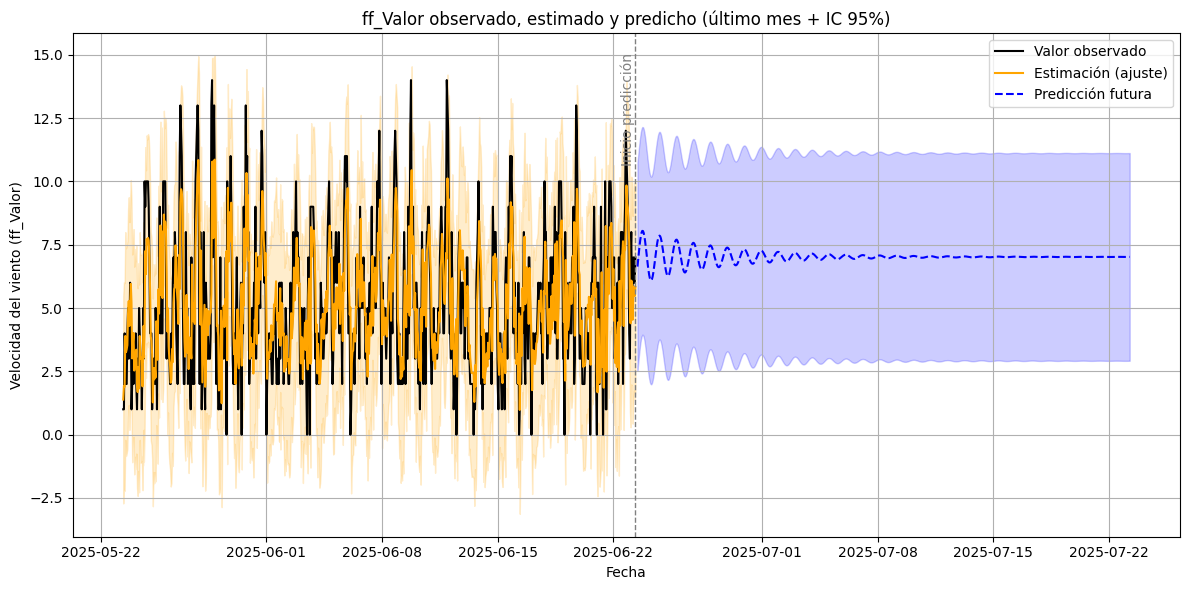

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Parámetros ---
RMSE = 2.0924  # Error estándar aproximado de la predicción (puedes ajustar esto)
z = 1.96       # Para intervalo de confianza del 95%

# Ordenar por fecha
datos = datos.sort_values("momento")

# Última fecha con dato observado
fecha_corte = datos.loc[datos["ff_Valor"].notna(), "momento"].max()
fecha_inicio = fecha_corte - pd.DateOffset(months=1)

# Datos observados (último mes con estimación)
datos_observado = datos[(datos["momento"] >= fecha_inicio) & (datos["momento"] <= fecha_corte)]
datos_observado = datos_observado.dropna(subset=["ff_Valor", "ff_Valor_estimado"]).copy()

# Datos predichos (posteriores a la última observación)
datos_pred = datos[(datos["momento"] > fecha_corte) & (datos["ff_Valor"].isna())]
datos_pred = datos_pred.dropna(subset=["ff_Valor_estimado"]).copy()

# Calcular IC del 95% para estimaciones
for df in [datos_observado, datos_pred]:
    df["IC_lower"] = df["ff_Valor_estimado"] - z * RMSE
    df["IC_upper"] = df["ff_Valor_estimado"] + z * RMSE

# --- Gráfico ---
plt.figure(figsize=(12, 6))

# Observado
plt.plot(datos_observado["momento"], datos_observado["ff_Valor"], label="Valor observado", color='black')
plt.plot(datos_observado["momento"], datos_observado["ff_Valor_estimado"], label="Estimación (ajuste)", color='orange')
plt.fill_between(datos_observado["momento"], datos_observado["IC_lower"], datos_observado["IC_upper"],
                 color='orange', alpha=0.2)

# Predicción
plt.plot(datos_pred["momento"], datos_pred["ff_Valor_estimado"], label="Predicción futura", color='blue', linestyle='--')
plt.fill_between(datos_pred["momento"], datos_pred["IC_lower"], datos_pred["IC_upper"],
                 color='blue', alpha=0.2)

# Línea vertical que marca el inicio de la predicción
plt.axvline(x=fecha_corte, color='gray', linestyle='--', linewidth=1)
plt.text(fecha_corte, plt.ylim()[1]*0.95, "Inicio predicción", color='gray', rotation=90, ha='right', va='top')

# Ajustes finales
plt.xlabel("Fecha")
plt.ylabel("Velocidad del viento (ff_Valor)")
plt.title("ff_Valor observado, estimado y predicho (último mes + IC 95%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# SARIMA

In [11]:
import pandas as pd
import numpy as np
import joblib
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 1. Cargar y preparar datos
datos = pd.read_excel("Datos_290004_con_predicciones_covariables_filtrado_2024.xlsx")
datos["momento"] = pd.to_datetime(datos["momento"])
datos = datos.sort_values("momento").set_index("momento")
datos = datos.asfreq('H')

# 2. Detectar datos faltantes de ff_Valor (se usarán como predicciones futuras)
datos["ff_Valor"] = datos["ff_Valor"].astype("float32")
es_futuro = datos["ff_Valor"].isna()

# 3. Rellenar ff_Valor solo para entrenamiento
serie_entrenamiento = datos["ff_Valor"].copy().fillna(method="ffill")

# 4. Separar datos de entrenamiento y prueba
indice_ultima_obs = serie_entrenamiento[~serie_entrenamiento.isna()].index[-1]
serie = serie_entrenamiento.loc[:indice_ultima_obs]

# 5. Definir ventana de entrenamiento
N = 5000
train = serie.iloc[-N:]

# 6. Ajustar modelo SARIMA
model = SARIMAX(
    train,
    order=(2, 0, 3),
    seasonal_order=(2, 1, 3, 24),
    simple_differencing=True,
    enforce_stationarity=False,
    enforce_invertibility=False
)
res = model.fit(disp=False)
print(res.summary())

# 7. Guardar modelo
joblib.dump(res, "modelo_sarima_opt.pkl")

# 8. Pronóstico completo (in-sample + out-of-sample)
n_total = len(datos)
pred = res.get_forecast(steps=n_total)
forecast = pred.predicted_mean
conf_int = pred.conf_int()

# 9. Crear columna con predicciones
ff_valor_estimado = pd.Series(index=datos.index, dtype='float32')
ff_valor_estimado.iloc[-n_total:] = forecast.astype("float32")

# 10. Guardar predicciones e intervalos de confianza
datos["ff_Valor_estimado"] = ff_valor_estimado
datos["IC_lower"] = conf_int.iloc[:, 0].astype("float32").values
datos["IC_upper"] = conf_int.iloc[:, 1].astype("float32").values

# 11. Evaluar solo donde haya datos reales
validacion = datos[~es_futuro].copy()
rmse = np.sqrt(mean_squared_error(validacion["ff_Valor"], validacion["ff_Valor_estimado"]))
mae = mean_absolute_error(validacion["ff_Valor"], validacion["ff_Valor_estimado"])
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")

# 12. Guardar resultados generales
datos.to_excel("datos_con_estimaciones_completas.xlsx")

# 13. Extraer predicciones futuras y guardar por separado
predicciones_futuras = datos[es_futuro][["ff_Valor_estimado", "IC_lower", "IC_upper"]]
predicciones_futuras.to_excel("predicciones_futuras.xlsx")



/tmp/ipython-input-11-1929885202.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  datos = datos.asfreq('H')
/tmp/ipython-input-11-1929885202.py:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  serie_entrenamiento = datos["ff_Valor"].copy().fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                      DS24.ff_Valor   No. Observations:                 4976
Model:             SARIMAX(2, 0, 3)x(2, 0, 3, 24)   Log Likelihood               -9541.389
Date:                            Wed, 09 Jul 2025   AIC                          19104.778
Time:                                    02:21:34   BIC                          19176.245
Sample:                                12-28-2024   HQIC                         19129.852
                                     - 07-23-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7753      0.441      1.757      0.079      -0.090       1.640
ar.L2         -0.0048      0.320   

prediccion


/tmp/ipython-input-13-438375750.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  datos = datos.asfreq("H")
/tmp/ipython-input-13-438375750.py:30: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  exog_train = exog_train.fillna(method="ffill").fillna(method="bfill")
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                           ff_Valor   No. Observations:                 3000
Model:             SARIMAX(2, 0, 3)x(2, 0, 3, 24)   Log Likelihood               -6137.320
Date:                            Wed, 09 Jul 2025   AIC                          12318.640
Time:                                    02:34:52   BIC                          12450.780
Sample:                                         0   HQIC                         12366.171
                                           - 3000                                         
Covariance Type:                              opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
dd_Valor        0.0035      0.000      8.185      0.000       0.003       0.004
VRB_Valor      -3.5326      0.19

/tmp/ipython-input-13-438375750.py:63: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  exog_futuro = exog_futuro.fillna(method="ffill").fillna(method="bfill")
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


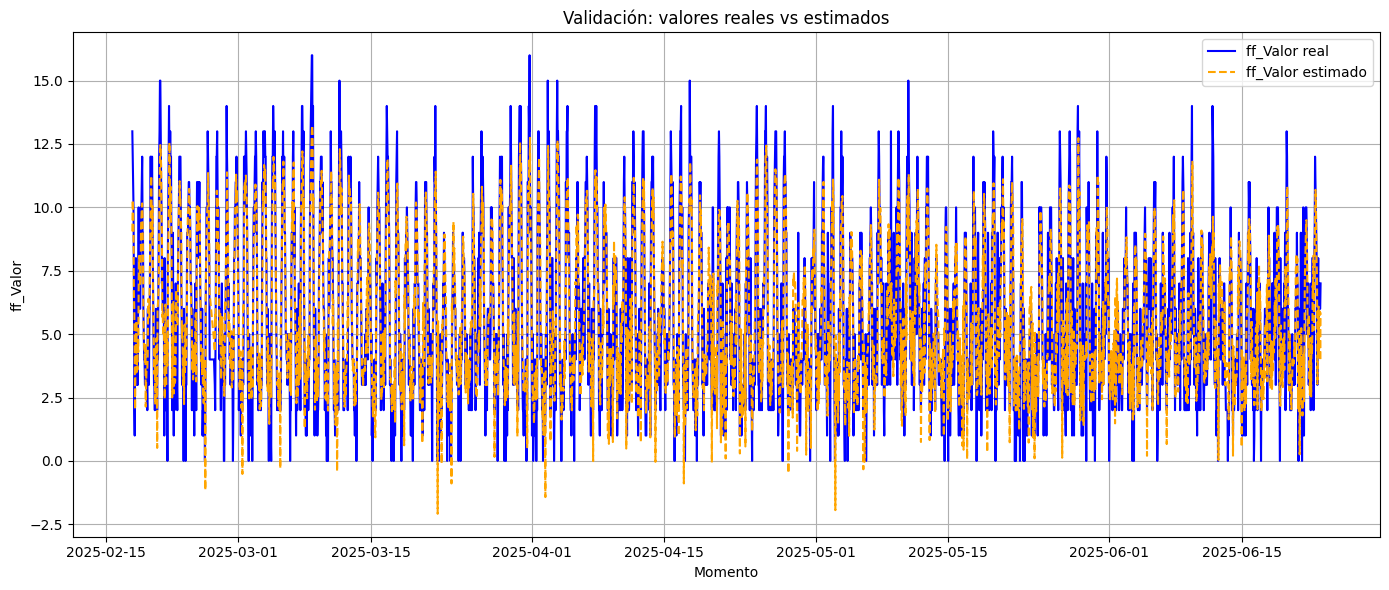

In [13]:
import pandas as pd
import numpy as np
import joblib
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# 1. Cargar datos
datos = pd.read_excel("Datos_290004_con_predicciones_covariables_filtrado_2024.xlsx")
datos["momento"] = pd.to_datetime(datos["momento"])
datos = datos.sort_values("momento").set_index("momento")
datos = datos.asfreq("H")

# 2. Variables exógenas
exog_vars = [
    "dd_Valor", "VRB_Valor", "Presion_QFE", "Temperatura", "Presion_QFF",
    "hora", "doy", "hora_sin", "hora_cos", "doy_sin", "doy_cos"
]

# 3. Últimas 3000 observaciones con ff_Valor válido
datos_train = datos[~datos["ff_Valor"].isna()].copy()
datos_train = datos_train[-3000:].astype("float32")

# Serie objetivo
y_train = datos_train["ff_Valor"]

# Exógenas para entrenamiento
exog_train = datos_train[exog_vars].copy()
exog_train = exog_train.replace([np.inf, -np.inf], np.nan)
exog_train = exog_train.fillna(method="ffill").fillna(method="bfill")

# 4. Ajustar modelo SARIMAX optimizado
model = SARIMAX(
    y_train,
    exog=exog_train,
    order=(2, 0, 3),
    seasonal_order=(2, 0, 3, 24),
    enforce_stationarity=True,
    enforce_invertibility=True
)
res = model.fit(disp=False)
print(res.summary())

# 5. Guardar modelo entrenado
joblib.dump(res, "modelo_sarimax_opt_mem.pkl")

# 6. Predicción in-sample (histórica)
pred_train = res.predict(start=y_train.index[0], end=y_train.index[-1], exog=exog_train)
datos.loc[y_train.index, "ff_Valor_estimado"] = pred_train

# 7. Métricas de validación
rmse = np.sqrt(mean_squared_error(y_train, pred_train))
mae = mean_absolute_error(y_train, pred_train)
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")

# 8. Predicción futura (720 pasos)
inicio_futuro = datos[datos["ff_Valor"].isna()].index.min()
fechas_futuras = datos.loc[inicio_futuro:].index[:720]

exog_futuro = datos.loc[fechas_futuras, exog_vars].astype("float32")
exog_futuro = exog_futuro.replace([np.inf, -np.inf], np.nan)
exog_futuro = exog_futuro.fillna(method="ffill").fillna(method="bfill")

forecast_futuro = res.get_forecast(steps=720, exog=exog_futuro).predicted_mean

# Asignar predicciones futuras al DataFrame
datos.loc[fechas_futuras, "ff_Valor_estimado"] = forecast_futuro.values

# 9. Guardar resultados
datos.to_excel("datos_estimados_modelo_exog_opt.xlsx")
forecast_futuro.to_frame(name="ff_Valor_estimado").to_excel("predicciones_futuras_720.xlsx")

# 10. Gráfico de validación histórica
plt.figure(figsize=(14, 6))
plt.plot(y_train.index, y_train, label="ff_Valor real", color="blue")
plt.plot(y_train.index, pred_train, label="ff_Valor estimado", color="orange", linestyle="--")
plt.title("Validación: valores reales vs estimados")
plt.xlabel("Momento")
plt.ylabel("ff_Valor")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipython-input-15-3648008682.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  indice_futuro = pd.date_range(start=ultimo_timestamp + pd.Timedelta(hours=1), periods=720, freq='H')


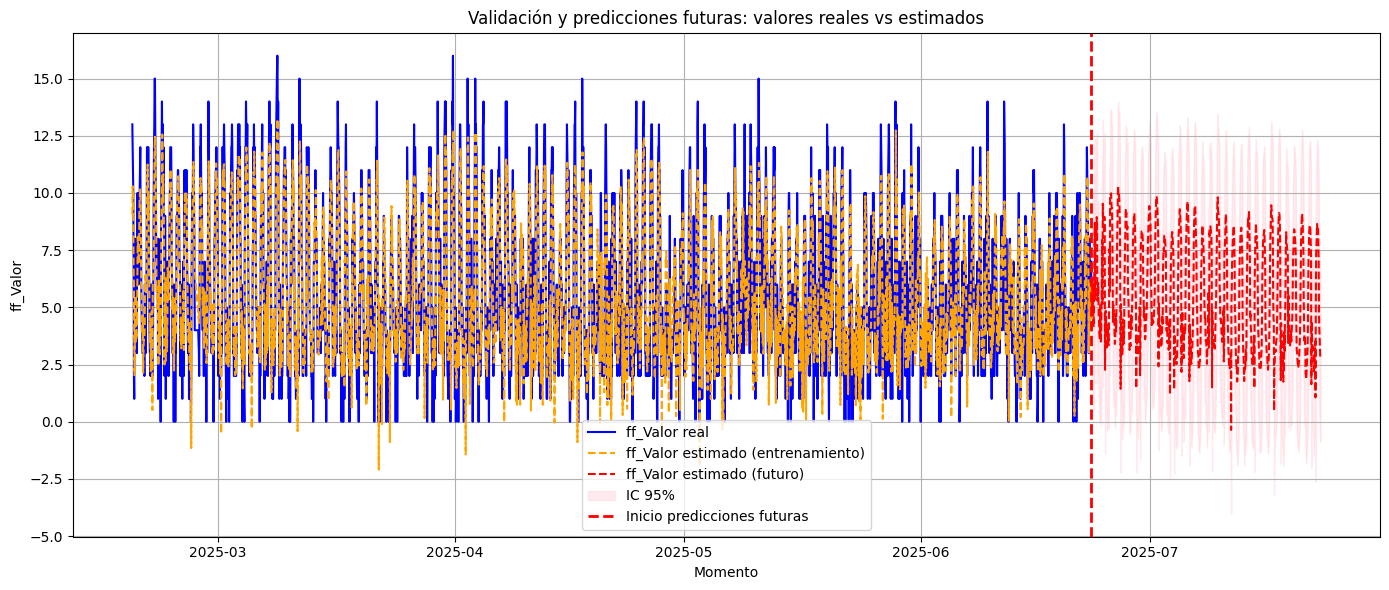

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Parámetros
z = 1.96
rmse = 1.8710

# 1. Corregir índice temporal de predicción futura
ultimo_timestamp = y_train.index[-1]
indice_futuro = pd.date_range(start=ultimo_timestamp + pd.Timedelta(hours=1), periods=720, freq='H')
forecast_futuro.index = indice_futuro

# 2. Calcular intervalos de confianza ± z * RMSE
lower_ic = forecast_futuro - z * rmse
upper_ic = forecast_futuro + z * rmse

# 3. Graficar
plt.figure(figsize=(14, 6))

# Serie real y entrenamiento
plt.plot(y_train.index, y_train, label="ff_Valor real", color="blue")
plt.plot(y_train.index, pred_train, label="ff_Valor estimado (entrenamiento)", color="orange", linestyle="--")

# Predicción futura y banda de confianza
plt.plot(forecast_futuro.index, forecast_futuro, label="ff_Valor estimado (futuro)", color="red", linestyle="--")
plt.fill_between(forecast_futuro.index, lower_ic, upper_ic, color="pink", alpha=0.3, label="IC 95%")

# Línea vertical: corte temporal
plt.axvline(x=ultimo_timestamp, color="red", linestyle="--", linewidth=2, label="Inicio predicciones futuras")

# Estética
plt.title("Validación y predicciones futuras: valores reales vs estimados")
plt.xlabel("Momento")
plt.ylabel("ff_Valor")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [16]:
df_pred=pd.read_excel("predicciones_futuras_720.xlsx")
print(df_pred.iloc[23])
print(df_pred.iloc[167])
print(df_pred.iloc[719])

Unnamed: 0           3023.000000
ff_Valor_estimado       4.492113
Name: 23, dtype: float64
Unnamed: 0           3167.000000
ff_Valor_estimado       3.780698
Name: 167, dtype: float64
Unnamed: 0           3719.000000
ff_Valor_estimado       2.868128
Name: 719, dtype: float64
